In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
from statsmodels.api import OLS,Logit
from sklearn.metrics import roc_curve,roc_auc_score
from scipy.stats import *

/home/users/magu/.local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
dataset='all_z_center_p001_20190805_500PCs'
npc=300 

# phenotypes to analyze
phe_codes=['INI21001','HC326','HC328'] 

# for regression models
covariate=['age','sex']+['PC'+str(i+1) for i in range(4)]

# load data
z=np.load('/oak/stanford/groups/mrivas/projects/degas-risk/datasets/train/tsvd/'+dataset+'.npz', allow_pickle=True)
scores=pd.read_table('/oak/stanford/groups/mrivas/projects/degas-risk/scorefiles/'+dataset+'.sscore',
                     index_col='#IID')
phenos=pd.read_table('/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/master_phe/master.phe',
                     usecols=['IID']+phe_codes+covariate,
                     index_col='IID',
                     na_values=-9)

# population groups
train=set(pd.read_table('/oak/stanford/groups/mrivas/projects/degas-risk/population-split/'+
                         'ukb24983_white_british_train.phe').iloc[:,0].astype(float).tolist())
valid=set(pd.read_table('/oak/stanford/groups/mrivas/private_data/ukbb/24983/sqc/population_stratification/'+
                         'ukb24983_non_british_white.phe').iloc[:,0].astype(float).tolist())

# phenotype names
with open('/oak/stanford/groups/mrivas/users/magu/repos/rivas-lab/ukbb-tools/05_gbe/icdinfo.txt','r') as f:
    code_to_name = {line.split()[0]:line.split()[2].replace('_',' ').split('(')[0].capitalize() for line in f}

# program some special cases
code_to_name['INI21001'] = 'Body mass index'
code_to_name['HC326'] = 'Myocardial infarction'
short={'INI21001':'BMI', 'HC326':'MI', 'HC328':'Gout'}

INI21001
27.1194150831
29.9508727273
29.8092620202
HC326
0.0302713987474
0.126506024096
0.138554216867
HC328
0.0170226433274
0.10843373494
0.114457831325


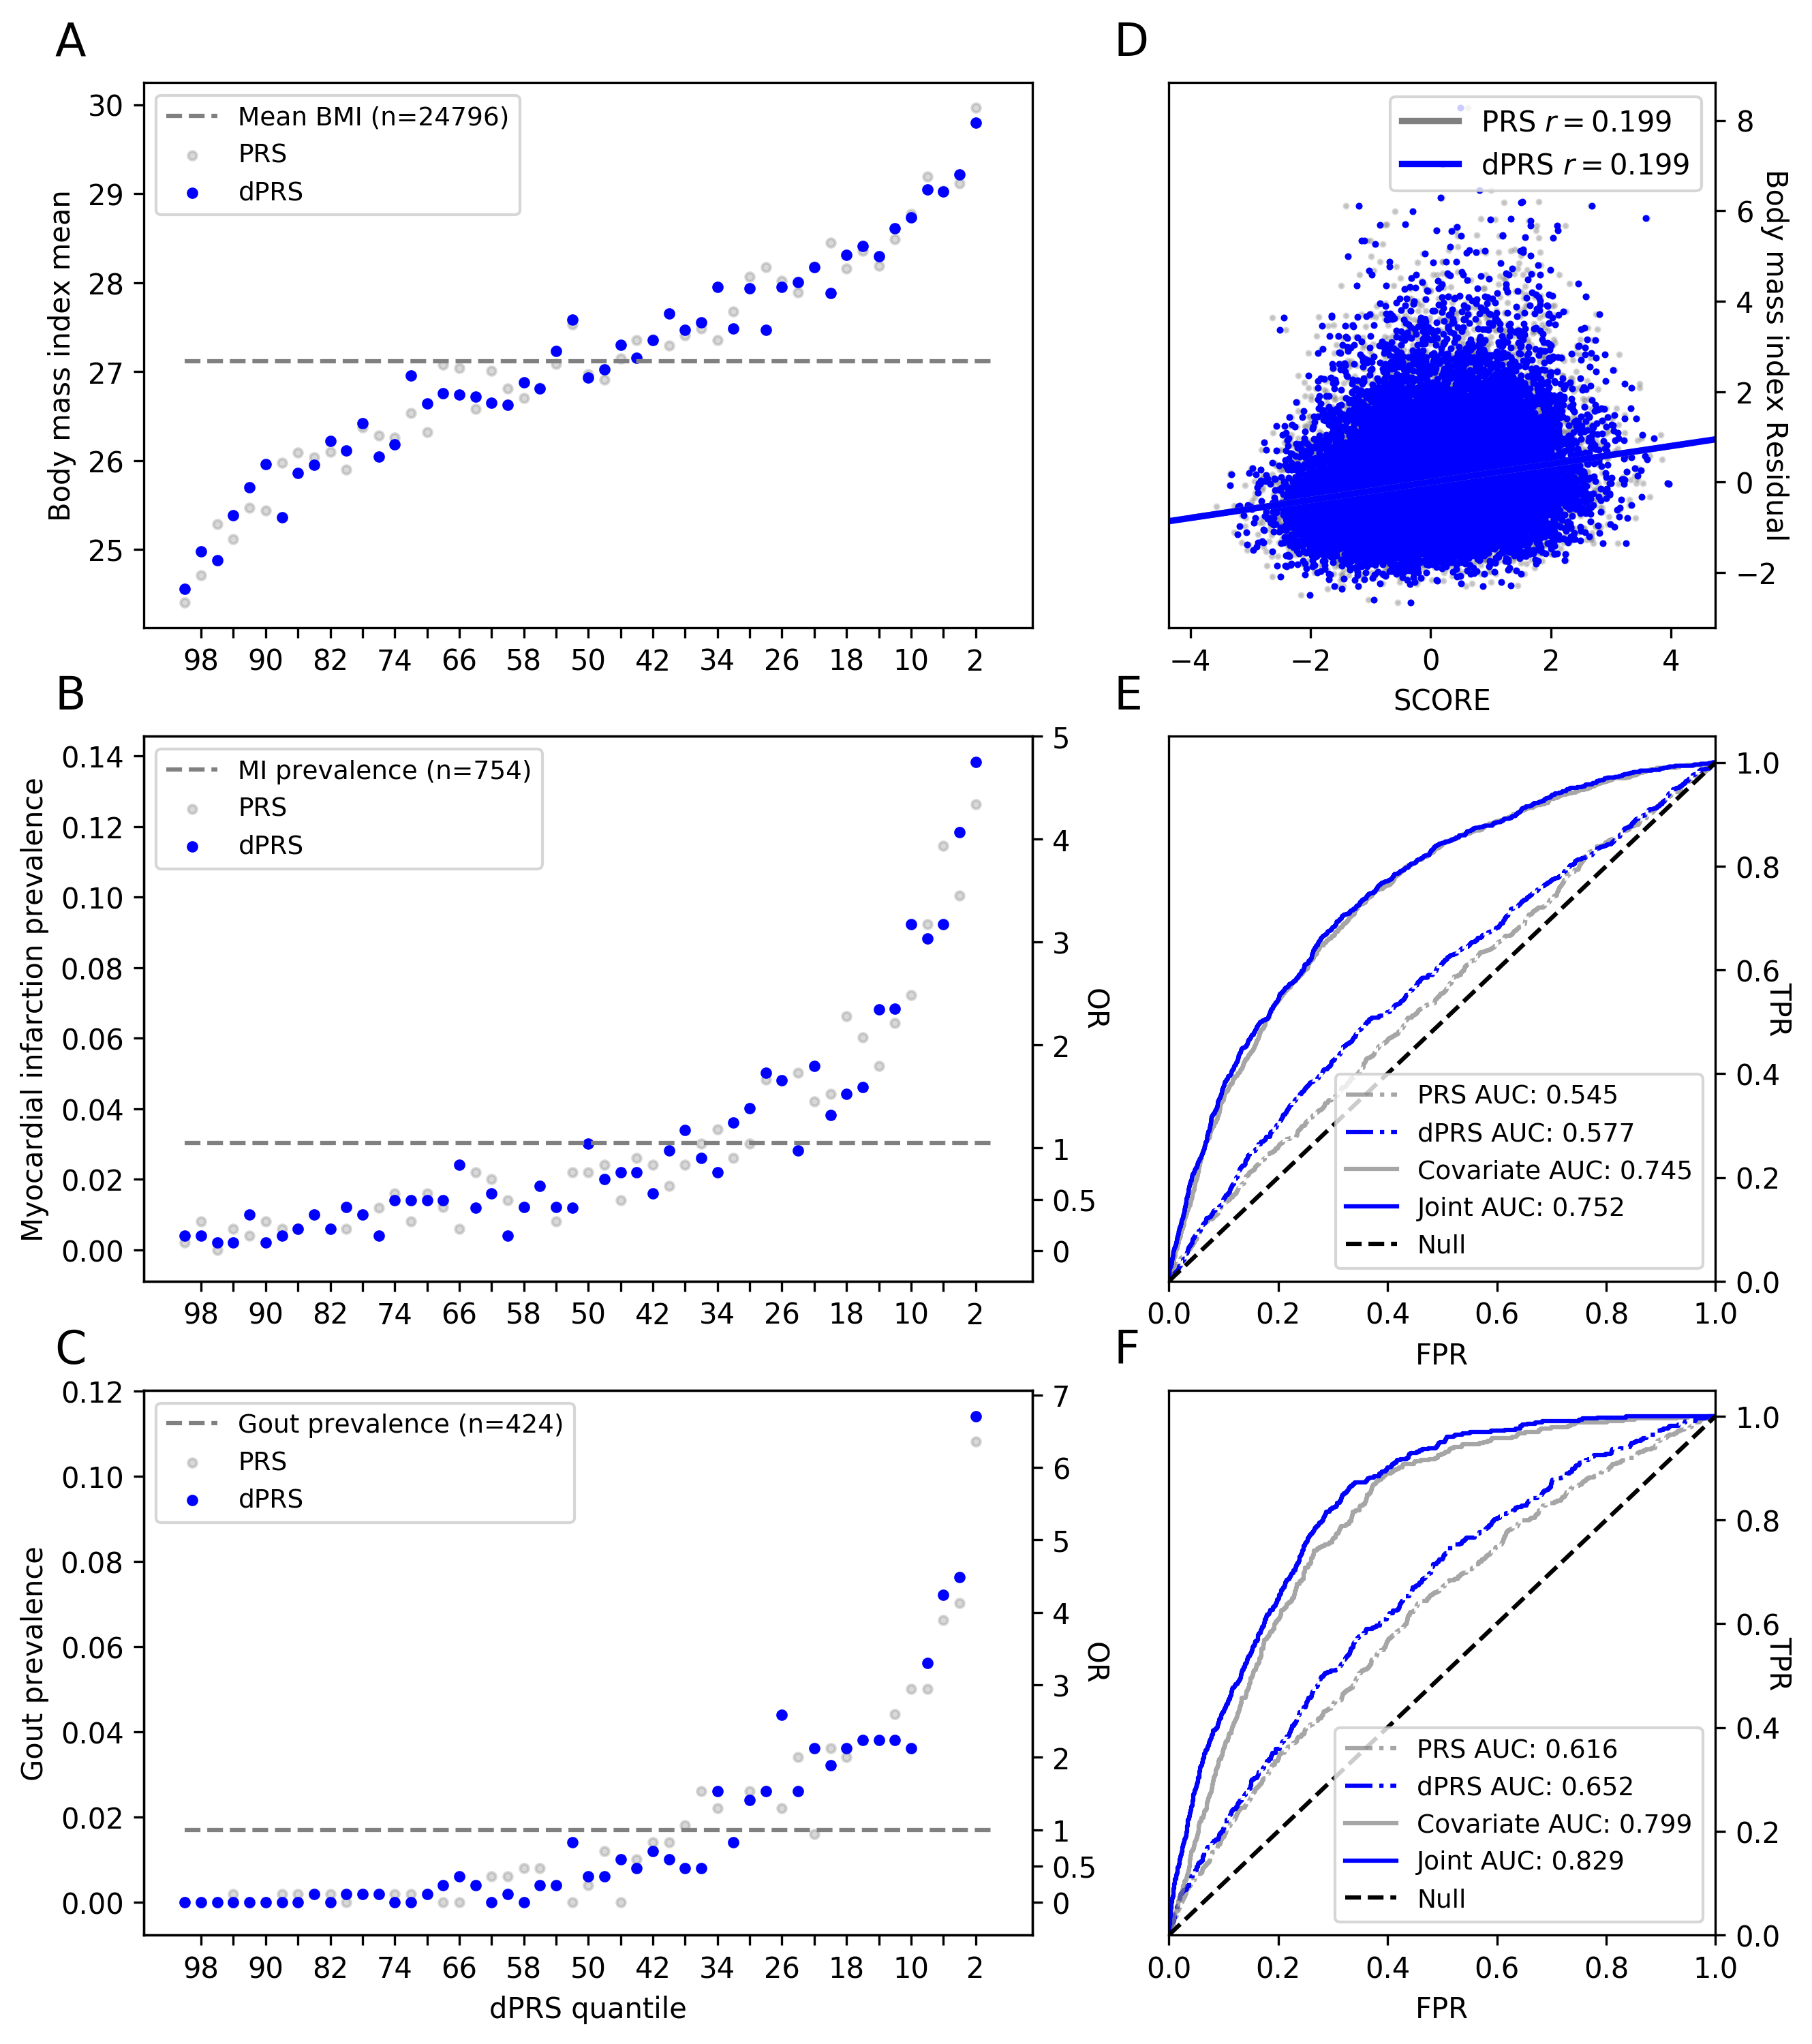

In [5]:
width = 2
# initialize plot objects
plots = [None for _ in range(width * len(phe_codes))]
plt.close('all'); plt.clf()
fig = plt.figure(figsize=(5*width + 1, 4*len(phe_codes)), dpi=300)
grid=gs.GridSpec(4*len(phe_codes), 5*width + 1, wspace=4, hspace=2)
for i,phe_code in enumerate(phe_codes):
    i = int(i)
    for ix in range(width):
        plots[(width*i)+ix]=plt.subplot(grid[i*4:(i+1)*4, (6*ix):(6-(7*ix))])
    # scores and phenotypes
    phe_name=code_to_name[phe_code]
    df=phenos.loc[valid,[phe_code]+covariate].dropna()
    dg=phenos.loc[train,[phe_code]+covariate].dropna()
    
    n=df.shape[0]
    weights=z['V'][np.where(z['label_phe_code'] == phe_code),:].flatten()[:npc]
    df['SCORE']=zscore(scores.loc[df.index.tolist(),
                                  ['SCORE{}_SUM'.format(k+1) for k in range(npc)]].dot(weights))
    dg['SCORE']=zscore(scores.loc[dg.index.tolist(),
                                  ['SCORE{}_SUM'.format(k+1) for k in range(npc)]].dot(weights))  
    # add prs, sort by value
    prs=pd.read_table('/oak/stanford/groups/mrivas/projects/degas-risk/PRS/train/'+dataset[:-7]+
                      '/'+phe_code+'_PRS.profile', 
                      sep='\s+',
                      usecols=['IID','SCORESUM'], index_col='IID')
    df['PRS']=zscore(prs.loc[df.index,'SCORESUM'])
    dg['PRS']=zscore(prs.loc[dg.index,'SCORESUM'])
    df.sort_values(by='SCORE',ascending=True,inplace=True)
    dg.sort_values(by='SCORE',ascending=True,inplace=True)
    # this is to add an intercept in the regression models below
    df['1']=1
    dg['1']=1
    covariates=covariate+['1']
    # start with check for bin/qt, and plotting distributions/AUC
    joint_model={}
    if len(df[phe_code].value_counts()) == 2:
        is_bin=True
        df[phe_code]-=1 # remove plink binary format
        dg[phe_code]-=1
        # loop over dPRS and these joint models
        cov_prs=Logit(dg[phe_code],dg[covariates]).fit(disp=0).predict(df[covariates])
        for prs in ['PRS','SCORE']:
            joint_model[prs]=Logit(dg[phe_code],dg[covariates+[prs]]).fit(disp=0).predict(df[covariates+[prs]])        
        for w,(name,prs) in enumerate(zip(['PRS','dPRS','Covariate','Joint'],
                                          [df['PRS'],df['SCORE'],cov_prs,joint_model[prs]])):
            # compute stats, plot them
            fpr,tpr,_=roc_curve(df[phe_code],prs)
            roc_auc=roc_auc_score(df[phe_code],prs)
            plots[(2*i)+1].plot(fpr,tpr,label=name+' AUC: '+'{:.3f}'.format(roc_auc), 
                                color='b' if w%2 else 'grey', alpha=0.7+0.3*(w%2), linestyle='-' if w/2 else '-.')
        # add null line, axis labels
        plots[(2*i)+1].plot([0, 1],[0, 1],'k--',label='Null')
        plots[(2*i)+1].legend(fontsize=9)
        plots[(2*i)+1].set_xlim([0.0, 1.0])
        plots[(2*i)+1].set_ylim([0.0, 1.05])
        plots[(2*i)+1].set_ylabel('TPR', rotation=270)
        plots[(2*i)+1].set_xlabel('FPR')
    else:
        is_bin=False
        # plot correlation with dPRS and residual phenotype
        for prs in ['PRS','SCORE']:
            joint_model[prs]=zscore(OLS(dg[phe_code],dg[covariates+[prs]]).fit(disp=0).predict(df[covariates+[prs]]))
            dprs=OLS(df[phe_code],df[covariates]).fit(disp=0).resid_pearson
            sns.regplot(x=df[prs], y=dprs, ax=plots[(2*i)+1],
                        scatter_kws={'s':2, 'alpha':0.3+0.7*(prs!='PRS')}, color='b' if prs!='PRS' else 'grey')
        plots[(2*i)+1].set_ylabel(code_to_name[phe_code]+' Residual', rotation=270)
        plots[(2*i)+1].legend([prs.replace('SCORE','dPRS')+' '+
                               '$r=$'+'{:.3f}'.format(pearsonr(dprs,df[prs])[0]) for prs in ['PRS','SCORE']])
    # now do quantile plot with modified (only if binary) phenotype
    nq=50
    print(phe_code)
    print(df[phe_code].mean())
    for prs,name in zip(['PRS','SCORE'],['PRS','dPRS']):
        df['joint']=joint_model[prs]
        df.sort_values('joint', ascending=True, inplace=True)
        plots[2*i].scatter(np.arange(nq), 
                           [df.iloc[int(q*n/nq):int((q+1)*n/nq),:][phe_code].mean() for q in range(nq)], 
                           s=9, c='b' if name=='dPRS' else 'grey', alpha=0.3+0.7*(name=='dPRS'))
        print(df.iloc[-(n/nq):][phe_code].mean())
    # labels
    plots[2*i].set_ylabel(phe_name+' {}'.format('prevalence' if is_bin else 'mean'))
    plots[2*i].set_xticks(np.arange(1,nq+1,2))
    plots[2*i].set_xticklabels([int(100*q/nq) if q%4==1 else '' for q in reversed(range(1,nq+1,2))])
    plots[2*i].plot([0,nq],[df[phe_code].mean(),df[phe_code].mean()],'--',color='grey')
    plots[2*i].legend(['{0} (n={1})'.format(short[phe_code]+' prevalence' if is_bin else 'Mean '+short[phe_code],
                                            int(df[phe_code].sum()) if is_bin else df.shape[0])]+['PRS','dPRS'], 
                       loc=2, fontsize=9)
    plots[2*i].text(-0.1, 1.05, chr((i%len(phe_codes))+65), 
                    fontsize=16, transform=plots[2*i].transAxes)
    plots[(2*i)+1].text(-0.1, 1.05, chr((i%len(phe_codes))+65+len(phe_codes)), 
                        fontsize=16, transform=plots[(2*i)+1].transAxes)
    # adjust y-axis to display odds ratios as well as prevalence (only binary traits)
    if is_bin:
        m,b=(plots[2*i].get_ylim()[1]-plots[2*i].get_ylim()[0]),plots[2*i].get_ylim()[0]
        y_or=plots[2*i].twinx()
        y_or.set_yticks([(o*df[phe_code].mean()-b)/m for o in [0,0.5,1,2,3,4,5,6,7,8,9] 
                          if df.iloc[-(n/nq):,:][phe_code].mean() > (o-1)*df[phe_code].mean()])
        y_or.set_yticklabels(map(lambda s:str(s), 
                                 filter(lambda o: df.iloc[-(n/nq):][phe_code].mean() > (o-1)*df[phe_code].mean(), 
                                        [0,0.5,1,2,3,4,5,6,7,8,9]))) 
        y_or.set_ylabel('OR',rotation=270)   
    plots[(2*i)+1].yaxis.tick_right()
    plots[(2*i)+1].yaxis.set_label_position("right")
    # add x-axis labels at the very end
    if i==len(phe_codes)-1:
        plots[(2*i)].set_xlabel('dPRS quantile')
    else:
        plots[(2*i)].set_xlabel('')
            
plt.show()
fig.savefig("pdfs/fig-s2.pdf", bbox_inches='tight')